## PyTorch Neural Network from scratch

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

# Make parent directory if not existed, ignore the error if directory existed
PATH.mkdir(parents=True, exist_ok=True)

# This is pkl not pk1
URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
#     use requests to get the file, access the response body through content through bytes/non-text
    content = requests.get(URL + FILENAME).content
#     writing + binary
    (PATH / FILENAME).open('wb').write(content)

In [2]:
import pickle
import gzip

# as_posix() windows_path --> posix_path(linux)
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
#     pickle is a Python module to seralize and deseralize data
    ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


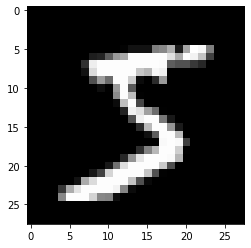

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape)

In [4]:
import torch

# torch.tensor 可以construct tensor，这里使用的是复制numpy array的方式
# 如果不想复制numpy array的话，可以用torch.as_tensor()
x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.shape)
print(x_train.min(), x_train.max())
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
torch.Size([50000])
tensor(0.) tensor(0.9961)
tensor(0) tensor(9)


In [5]:
import math
# Xavier innitialisation: weights matrix from [0, 1]divided by sqrt(n) 
# n: number of neurons in the corresponding layer
weights = torch.randn(784, 10) / math.sqrt(784)
# '_' trailing: performed in-place
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
#     例如output[32, 10] --> [32, 1]-->[32,]
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
#     这里也可以用Tensor.mm()
    return log_softmax(xb @ weights + bias)

In [7]:
# batch_size
bs = 64

xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.1787, -1.8506, -2.0425, -2.3958, -2.2967, -2.6759, -2.3255, -2.8313,
        -2.7089, -2.1529], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
# 非常小心的一点是，这是说是NLL negative log likelihood loss，但是其实只是mean nagative likelihood loss 而已
# 网络的输出已经经过log了
# 这里使用了range(target.shape[0])， 实际输出range(0, 64)，意思是在batch_size这个dimension 上选0-63，
# 而对应每个sample 取target 那个的标签。这个功能也可以用torch.gather()实现
def nll(input, target):
    batch_range = range(target.shape[0])
    return -input[batch_range, target].mean()

loss_func = nll

<img src='./fig/Tensor_index.png' width=700 align='left'>

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4295, grad_fn=<NegBackward>)


In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return(preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.0156)


In [12]:
from IPython.core.debugger import set_trace
lr = 0.5
epochs = 2
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
#         set_trace()
#         注意这里没有batch的设置，但是在使用dataset refactor的时候可以使用batch
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        print(loss.item())
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

2.4295337200164795
1.9695050716400146
1.9009286165237427
1.6275380849838257
1.355352520942688
1.0061415433883667
0.922238290309906
1.0488682985305786
0.9463463425636292
1.1573047637939453
0.9329898953437805
0.9808358550071716
0.8489398956298828
0.9802277684211731
1.0543029308319092
0.7514306902885437
1.004091739654541
0.9661435484886169
0.5454010367393494
0.6689472198486328
0.7393567562103271
1.024264931678772
1.095572590827942
0.9292601943016052
0.5112167596817017
0.5293198823928833
0.41545557975769043
0.5275112390518188
0.5792365074157715
0.47159576416015625
0.49069684743881226
0.5089037418365479
0.4620976746082306
0.3331240713596344
0.4982525408267975
0.4495408535003662
0.3910275101661682
0.6135691404342651
0.4904988706111908
0.34612125158309937
0.4225466251373291
0.5994874238967896
0.6270489692687988
0.5292664170265198
0.3434979021549225
0.4801288843154907
0.4175183176994324
0.6124203205108643
0.4209957420825958
0.3572678565979004
0.42078161239624023
0.46841394901275635
0.406177580

0.774145245552063
0.5771186947822571
0.40142613649368286
0.1701907068490982
0.30918264389038086
0.49469906091690063
0.6295095682144165
0.40859436988830566
0.29049602150917053
0.2993665039539337
0.3673185408115387
0.3765139877796173
0.37049537897109985
0.4729433059692383
0.3676651418209076
0.4948062002658844
0.480194091796875
0.4796765446662903
0.48111289739608765
0.2642470598220825
0.12928080558776855
0.4478495121002197
0.30694836378097534
0.5541710257530212
0.27768003940582275
0.36309903860092163
0.2535833716392517
0.2835923135280609
0.23566433787345886
0.2300799936056137
0.32570573687553406
0.38057783246040344
0.4244438409805298
0.3660382330417633
0.3018668293952942
0.2872979938983917
0.1764853149652481
0.1824893355369568
0.39774033427238464
0.15273337066173553
0.1006225198507309
0.16070368885993958
0.18950322270393372
0.28216421604156494
0.19816112518310547
0.23087626695632935
0.20542722940444946
0.19989335536956787
0.32026106119155884
0.47354668378829956
0.537994384765625
0.3364085

0.26664999127388
0.2394067347049713
0.16238558292388916
0.1347438395023346
0.33366042375564575
0.1503206044435501
0.20113104581832886
0.2354113608598709
0.2770374119281769
0.5578001141548157
0.4311559498310089
0.5623863935470581
0.45028117299079895
0.1918216347694397
0.32940223813056946
0.2069171816110611
0.21587443351745605
0.3203088641166687
0.2164478600025177
0.4744015634059906
0.2652137279510498
0.2991475760936737
0.3499477505683899
0.30651456117630005
0.40361297130584717
0.6256300806999207
0.6591168642044067
0.5079219341278076
0.35079094767570496
0.20021586120128632
0.2511316239833832
0.529048502445221
0.5785512924194336
0.4632658064365387
0.3956384062767029
0.2484542578458786
0.2843848466873169
0.26315492391586304
0.30728742480278015
0.19801899790763855
0.3833433985710144
0.12003475427627563
0.450297474861145
0.4171110987663269
0.20196205377578735
0.37207505106925964
0.29704344272613525
0.6132158041000366
0.4879414439201355
0.3790995478630066
0.3444272577762604
0.3305028975009918

0.20137378573417664
0.37234604358673096
0.31412473320961
0.26681235432624817
0.2734246253967285
0.37129080295562744
0.17901091277599335
0.18156608939170837
0.2055858075618744
0.4789082407951355
0.24652770161628723
0.27816295623779297
0.2209993302822113
0.3413044512271881
0.5025866031646729
0.31320512294769287
0.6157188415527344
0.3799436092376709
0.40831446647644043
0.2013695240020752
0.19731922447681427
0.2783111035823822
0.20887354016304016
0.19431942701339722
0.3245672881603241
0.5057836771011353
0.24403473734855652
0.32681384682655334
0.31411057710647583
0.1472833901643753
0.6744614243507385
0.255066454410553
0.6679619550704956
0.6264370083808899
0.1491003930568695
0.24817582964897156
0.3436248004436493
0.3603939116001129
0.3900687098503113
0.4272272288799286
0.4074840545654297
0.2616318464279175
0.3075196146965027
0.28255343437194824
0.4408625364303589
0.09109967201948166
0.22258135676383972
0.13801100850105286
0.14245744049549103
0.3510485589504242
0.1265958994626999
0.3720127344

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0831, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

In [14]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0831, grad_fn=<NllLossBackward>) tensor(1.)


## Using torch.nn.Module
这个module与tf.keras.Model 有异曲同工之妙

In [16]:
from torch import nn

class MnistLogistic(nn.Module):
    
    def __init__(self):
        super().__init__()
#         nn.parameter 是一个Tensor的subclass，当与nn.Module一起使用的时候，能自动嵌入到nn.Module中
        self.weights = nn.Parameter(torch.randn(784, 10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [17]:
model = MnistLogistic()

In [18]:
print(loss_func(model(xb), yb))

tensor(2.3094, grad_fn=<NllLossBackward>)


In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
#                 注意区别，对于一个model，那就是model.zero_grad()
#                 而对于每个Tensor，那就是Tensor.grad.zero_() in-place zero
                model.zero_grad()
fit()
                

In [20]:
print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    def forward(self, xb):
        return self.lin(xb)

In [22]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2839, grad_fn=<NllLossBackward>)


In [23]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


## Refactor using optim

In [24]:
from torch import optim

In [25]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.2942, grad_fn=<NllLossBackward>)


In [26]:
for epoch in range(epochs):
    for i in range((n-1) // bs +1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
#         用了optim以后就不需要with torch.no_grad()和model.zero_grad()了
#         with torch.no_grad()只用于validation 以及 inference
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


## Refactor using Dataset

In [27]:
from torch.utils.data import TensorDataset

In [28]:
print(x_train.shape, y_train.shape)
print()

torch.Size([50000, 784]) torch.Size([50000])



In [29]:
# Warpping Tensors. Each sample will be retrieved by indexing tensors along the first dimension.
# 会自动将若干输入的Tensor沿着first dimension 打包成 tuple，所以所有Tensor.size(0)都会像等
train_ds = TensorDataset(x_train, y_train)

In [30]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i*bs: i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward>)


## Refactor using Dataloader

Dataloader相比dataset的好处是增加了自动mini-batch, shuffle以及multi-thread

In [31]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [32]:
model, opt = get_model()

for epoch in range(epochs):
#     虽然现在在前面多了一层batch dimension，但是可以用xb, yb in train_dl这样的iteration来处理，PyTorch能自动处理
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


## Add validation

In [33]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs*2)

In [34]:
model, opt = get_model()
for epoch in range(epochs):
#   在training前使用model.train() 在inference前使用model.eval() 能改变model中dropout和batch_norm的行为
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
#   在inference前使用model.eval()
    model.eval()
    with torch.no_grad():
#         这里的sum能够承接多个对象
        val_loss = sum(loss_func(model(xb), yb) for xb, yb in val_dl)
        
    print(epoch, val_loss.item() / len(val_dl))
        
    

0 0.3309369147578372
1 0.3421630617938464


In [35]:
# 这个有点像tf中的train batch

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [36]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl])
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

In [37]:
def get_data(train_ds, val_ds, bs):
    return(
    DataLoader(train_ds, batch_size=bs, shuffle=True),
    DataLoader(val_ds, batch_size=bs*2),)

In [38]:
train_dl, val_dl = get_data(train_ds, val_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.30750353588461876
1 0.3110940942108631


## Switch to CNN

In [39]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
#       (28 + padding * 2 -(kernel_size -1))/stride = (28 + 1*2 -(3-1))/2 = 14
        xb = F.relu(self.conv2(xb))
#       (14 + padding * 2 -(kernel_size -1))/stride = (14 + 1*2 -(3-1))/2 = 7
        xb = F.relu(self.conv3(xb))
#       (7 + padding * 2 -(kernel_size -1))/stride = (7 + 1*2 -(3-1))/2 = 3.5 = 4
        xb = F.avg_pool2d(xb, kernel_size=4)
#       avgpooling 2d: (4 - (kernel_size-1))/stride = (4 -(4-1)) / 1 = 1
        return xb.view(-1, xb.size(1))

In [40]:
print(xb.size())

torch.Size([16, 784])


In [41]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# 注意这里的loss_func 是 crossentropy，包含log-softmax和negative likelihood loss
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.33377406539916993
1 0.3164267322063446


## nn.sequential and custom layer

In [42]:
# 这里的custom layer也是跟custom model一样，是nn.Module的subclass，使用sequential model的时候一定要用nn.Module的subclass
# 加载进去，不可以直接用lambda function或者是
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
#         print(x.size())
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(Lambda(preprocess),
                     nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
                     nn.AvgPool2d(4),
                     Lambda(lambda x: x.view(-1, x.size(1))))

In [43]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.6344017515182495
1 0.5646419269561768


## Wrapping Dataloader

In [44]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

# yield 能得到一个generator对象
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, val_dl = get_data(train_ds, val_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)

In [46]:
model = nn.Sequential(
                     nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
                     nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
                     nn.ReLU(),
#                    AdaptiveAvgPool2d could return arbitary spatial size of output
                     nn.AdaptiveAvgPool2d(1),
                     Lambda(lambda x: x.view(x.size(0), -1)))

In [47]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [48]:
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.49939156489372255
1 0.4860512022018433


## Using GPU

In [49]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [50]:
# 将dataloader的所有batch都移动到GPU上
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)
train_dl, val_dl = get_data(train_ds, val_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)

In [51]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [52]:
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.4594813583850861
1 0.42788300681114194
